In [ ]:
from bs4 import BeautifulSoup
import re
import os
import pandas as pd 
import numpy as np 
import requests
import csv
import base64
import glob
from scipy.stats import zscore
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Loading data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
# Download data rar
!gdown 1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV -O data.rar

Downloading...
From (uriginal): https://drive.google.com/uc?id=1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV
From (redirected): https://drive.google.com/uc?id=1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV&confirm=t&uuid=9211339a-493d-40a3-8417-eada79726216
To: /content/data.rar
100% 314M/314M [00:03<00:00, 87.9MB/s]


In [ ]:
!mkdir subjects
!unrar x "/content/data.rar" "/content/subjects/"
!rm -r "data.rar"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/data.rar

Extracting  /content/subjects/ana_press_6_esfand.csv                       0%  OK 
Extracting  /content/subjects/ana_press_all.csv                            1%  OK 
Extracting  /content/subjects/asriran_6_esfand.csv                         1%  OK 
Extracting  /content/subjects/asriran_all.csv                              3%  4%  5%  6%  OK 
Extracting  /content/subjects/entekhab_6_esfand.csv                        6%  OK 
Extracting  /content/subjects/entekhab_all.csv                             7%  9% 10% 11% 13% 14% 15%  OK 
Extracting  /content/subjects/farsnews_6_esfand.csv                       15%  OK 
Extracting  /content/subjects/farsnews_all.csv                            16% 18% 19% 21% 22% 23% 25% 26% 27% 29%  OK 
Extractin

# Feature Extraction


In [ ]:
def intersection_ratio(title, content, content_len):
    """ max[ (intersect(title , content) / content_len) , 0] """

    intersection = np.intersect1d(title , content)
    try:
        return max((len(intersection)/content_len), 0) # ignore negative ratio
    except:
        return 0

In [ ]:
def choose_description(df_output):   
    """ choose the deepest description and act as regular content to others. """
    
    idx_list = []
    depth_list = []
    x = df_output.loc[df_output['label']==1].index

    for idx in x:
        idx_list.append(idx)
        depth_list.append(df_output.loc[idx, 'depth'])

    if depth_list:
        idx_max = np.array(depth_list).argmax()
        real_desc_idx = idx_list[idx_max]

        for element in idx_list:
            if element != real_desc_idx:
                df_output.loc[element, 'label'] = 0

    return df_output

In [ ]:
def feature_extractor(html_doc:str, title:str, description:str, ignore_ratio=3, training_mode=True):
    """ the function to extract features from one html document.
        it gets title and description in string format as inputs.
        ignore_ratio default value is 3 which means text in tages with less than 3 words in html doc will be ignored.
        labels are assigned if training mode is true otherwise labels won't be created.
        in test mode, descriotion should be assigned as None"""

    splited_title = np.array(title.split())
    content_list = []
    intersection_ratio_list = []
    content_depth_list = []
    content_len_list = []
    dom_tree_types = []
    labels = []
    

    def traverse(t, current_path=None):

        if current_path is None:
            current_path = [t.name] # example -> current_path = ['body']

        for tag in t.find_all(recursive=False):

            if not tag.find():        
                    path = current_path + [tag.name, tag.find(string=True)] # example -> path: ['body', 'div', 'h2', 'hello world!']
                    content = tag.find(string=True) # each string in tag as a content

                    if str(content) != 'None' and str(tag.name) != 'script' and str(tag.name) != 'style':
                          content = tag.find(string=True).strip()                     
                          splited_content = str(content).split()  # example -> splitted_content: hello, world!
                          content_len = len(splited_content) # example -> number of words in content: 2

                          if content_len > ignore_ratio:

                              if training_mode == True: # assign labels
                                  
                                  if str(content) == description:
                                    labels.append(1)

                                  elif str(content) == title:
                                    labels.append(2)

                                  else:
                                    labels.append(0)

                              content_list.append(str(content)) # example -> content: hello world!
                              content_depth_list.append(float(len(path))) # example -> depth: 4
                              content_len_list.append(content_len) # example -> number of words: 2
                              dom_tree_types.append(tag.name) # example -> tag: h2
                              intersection_ratio_list.append(intersection_ratio(splited_title, splited_content, content_len))
                                            
            else:
                traverse(tag, current_path + [tag.name])
            
    soup = BeautifulSoup(html_doc, "html.parser")
    traverse(soup.body)
    # traverse(soup.find("article", {'class': 'news-content'})) # varzesh3

    # z score normalization on content_len in each indiviual html doc
    content_len_list = zscore(content_len_list)

    # lists to dictionary
    if training_mode == True:
      data_dict = {'content': content_list,
                  'depth': content_depth_list,
                  'intersection_ratio' : intersection_ratio_list ,
                  'content_len': content_len_list, 
                  'dom_tree_type':dom_tree_types,
                  'label': labels}  
    if training_mode == False:
      data_dict = {'content': content_list,
                  'depth': content_depth_list,
                  'intersection_ratio' : intersection_ratio_list ,
                  'content_len': content_len_list, 
                  'dom_tree_type':dom_tree_types}  
        
    # dict to df
    df_output = pd.DataFrame(data_dict)

    # if more than 1 description we have, choose the deepest one
    if training_mode == True:
      if len(df_output[df_output['label'] >= 2]):
          df_output = choose_description(df_output)

    return df_output

In [ ]:
# html to df on one sample html testing
html_doc = """
<head>
   <meta property="og:title" content="this is a title.">
   <meta property="og:description" content="this is a description.">
</head>
<body>
   <h2><a>this is a title.</a></h2>
   <h1>this is a title.</h1>
   <p>this is a description.</p>
   <p>this is a text.</p>
   <p>apple</p>
   <span>
      <p>Google Chrome is a web browser</p>
      <p>Chrome is a web browser developed by google </p>
      <div>
         <div>
            <p>This is a leaf node</p>
            <p>This is a leaf node</p>
            <p>This is a leaf node</p>
            <p><div><div>this is a description.</div></div></p>
            <p><li>this is a description.</li></p>
         </div>
      </div>
   </span>
</body>
""" 

soup = BeautifulSoup(html_doc, "html.parser")

title = soup.find('meta', {'property': 'og:title'})["content"]
print('title:', title)
# title = soup.find('h2').text.strip()

description = soup.find('meta', {'property': 'og:description'})["content"]
print('description:', description)

df_sample = feature_extractor(html_doc, title, description, ignore_ratio=3, training_mode=True)
# df_sample = feature_extractor(html_doc, title, description=None, ignore_ratio=3, training_mode=False)
df_sample

title: this is a title.
description: this is a description.


,content,depth,intersection_ratio,content_len,dom_tree_type,label
0,this is a title.,4.0,1.000000,-0.686244,a,2
1,this is a title.,3.0,1.000000,-0.686244,h1,2
2,this is a description.,3.0,0.750000,-0.686244,p,0
3,this is a text.,3.0,0.750000,-0.686244,p,0
4,Google Chrome is a web browser,4.0,0.333333,0.991241,p,0
5,Chrome is a web browser developed by google,4.0,0.250000,2.668725,p,0
6,This is a leaf node,6.0,0.400000,0.152499,p,0
7,This is a leaf node,6.0,0.400000,0.152499,p,0
8,This is a leaf node,6.0,0.400000,0.152499,p,0
9,this is a description.,8.0,0.750000,-0.686244,div,1


# News Web Pages Processor


In [ ]:
def news_pages_processor(news_df):
    """ The function gets one csv of one news agancy.
        Each csv contains many html docs.
        Each html doc is in base64 format.
        Each html doc reprasents one news web page.
        This function uses feature extractor function,
        and return one df includes features of one news agency"""

    output = pd.DataFrame(columns=['content','depth', 'intersection_ratio','content_len', 'dom_tree_type', 'label']) 

    for i in tqdm(range(len(news_df['html']))):
        html_string = base64.b64decode(news_df['html'][i].encode("utf-8", 'ignore')) # type: byte
        html_doc = html_string.decode("utf8", 'ignore') # type: string. To avoid unicode error use ignore

        # finding title and description in the web page
        soup = BeautifulSoup(html_doc, "html.parser")
        try:
            description = soup.find('meta', {'property': 'og:description'})["content"]
        except:
            description = False
        try:
            title = soup.find('meta', {'property': 'og:title'})["content"]
        except:
            title = False

        if title and description : # since some pages are 403 Forbidden!
            output = output.append(feature_extractor(html_doc, title, description, ignore_ratio=4, training_mode=True))

    """ z score normalization on depth column in each news agency"""
    output['depth'] = zscore(output['depth'])

    return output

In [ ]:
def normalize_dom_intersection(output):
    """ assign int value to dom tree types then apply z score normalization"""
    le = LabelEncoder() # Creating a instance of label Encoder.
    types = le.fit_transform(output['dom_tree_type'])
    output.drop("dom_tree_type", axis=1, inplace=True)
    output["dom_tree_type"] = types

    """ z score normalization on dom tree and intersection_ratio """
    output['intersection_ratio'] = zscore(output['intersection_ratio'])
    output['dom_tree_type'] = zscore(output['dom_tree_type'])
    return output

# Applying on all data

In [ ]:
ana_press_all =  news_pages_processor(pd.read_csv('/content/subjects/ana_press_all.csv', encoding='utf8', on_bad_lines='skip'))
asriran_all =  news_pages_processor(pd.read_csv('/content/subjects/asriran_all.csv', encoding='utf8', on_bad_lines='skip'))
# entekhab_all = news_pages_processor(pd.read_csv('/content/subjects/entekhab_all.csv', encoding='utf8', on_bad_lines='skip'))
# farsnews_all = news_pages_processor(pd.read_csv('/content/subjects/farsnews_all.csv', encoding='utf8', on_bad_lines='skip'))
# iscanews_all = news_pages_processor(pd.read_csv('/content/subjects/iscanews_all.csv', encoding='utf8', on_bad_lines='skip'))
# isna_all = news_pages_processor(pd.read_csv('/content/subjects/isna_all.csv', encoding='utf8', on_bad_lines='skip'))
# jahannews_all = news_pages_processor(pd.read_csv('/content/subjects/jahannews_all.csv', encoding='utf8', on_bad_lines='skip'))
# khabaronline_all = news_pages_processor(pd.read_csv('/content/subjects/khabaronline_all.csv', encoding='utf8', on_bad_lines='skip'))
# mashreghnews_all = news_pages_processor(pd.read_csv('/content/subjects/mashreghnews_all.csv', encoding='utf8', on_bad_lines='skip'))
# mehrnews_all = news_pages_processor(pd.read_csv('/content/subjects/mehrnews_all.csv', encoding='utf8', on_bad_lines='skip'))
# shana_all = news_pages_processor(pd.read_csv('/content/subjects/shana_all.csv', encoding='utf8', on_bad_lines='skip'))
# tasnimnews_all = news_pages_processor(pd.read_csv('/content/subjects/tasnimnews_all.csv', encoding='utf8', on_bad_lines='skip'))
# varzesh3_all = news_pages_processor(pd.read_csv('/content/subjects/varzesh3_all.csv', encoding='utf8', on_bad_lines='skip'))
# yjcnews_all = news_pages_processor(pd.read_csv('/content/subjects/yjcnews_all.csv', encoding='utf8', on_bad_lines='skip'))

  0%|          | 0/1959 [00:00<?, ?it/s]

  0%|          | 0/4169 [00:00<?, ?it/s]

In [ ]:
# concatenating dfs
df_list = [ana_press_all,
           asriran_all, ]
          #  entekhab_all, 
          #  farsnews_all, 
          #  iscanews_all, 
          #  isna_all, 
          #  jahannews_all, 
          #  khabaronline_all, 
          #  mashreghnews_all, 
          #  mehrnews_all, 
          #  shana_all, 
          #  tasnimnews_all, 
          #  varzesh3_all, 
          #  yjcnews_all]

output = pd.concat(df_list, axis=0, ignore_index=True)
output = normalize_dom_intersection(output)

In [ ]:
# main df of all dataset
output

,content,depth,intersection_ratio,content_len,label,dom_tree_type
0,دیده بان پیشرفت علم، فناوری و نوآوری,-1.782091,-0.450605,-0.207098,0,1.854340
1,دیده بان پیشرفت علم، فناوری و نوآوری,-1.782091,-0.450605,-0.207098,0,1.854340
2,زیست بوم دانش و فناوری,1.406763,-0.450605,-0.249918,0,1.854340
3,انقلاب اسلامی و دفاع مقدس,1.406763,-0.450605,-0.249918,0,1.854340
4,زیست بوم دانش و فناوری,-0.719140,-0.450605,-0.249918,0,1.854340
...,...,...,...,...,...,...
203978,قانون شماره 5: بیشتر از دهان، گوشتان را باز كنید,-0.216943,-0.450605,0.193851,0,1.854340
203979,قانون شماره 6: برای ماندن برنامه‌ریزی كنید,-0.216943,-0.450605,-0.484628,0,1.854340
203980,عضویت در اینستاگرام عصر ایران,0.385849,-0.450605,-0.936947,0,-0.624025
203981,اخبار و تحلیل های ترکیه,1.591434,-0.450605,-0.936947,0,1.854340


# Saving feature_df for future uses

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# output.to_csv('/content/drive/MyDrive/output.csv', encoding='utf-8')

In [ ]:
# df_out_csv = pd.read_csv('/content/drive/MyDrive/output.csv')

# Training models

## Extra Trees Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [ ]:
def confusion_matrix_(test_labels, predicted_labels, version):
    if not os.path.exists('result'):
        os.makedirs('result')

    print("\nconfusion_matrix\n")
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.subplots(figsize=(10, 6))
    sn.heatmap(cm, annot = True, fmt = 'd', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    # plt.savefig(f'result/confusion_matrix_{version}.png', bbox_inches='tight')

def model_result(y_test,y_pred, version):
    ra_score = roc_auc_score(y_test,y_pred)
    a_score = accuracy_score(y_test,y_pred)
    p_score = precision_score(y_test,y_pred)
    r_score = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    
    print('roc_auc_score : ',ra_score)
    print('accuracy_score: ',a_score)
    print('precision_score: ',p_score)
    print('recall_score: ',r_score)
    print('f1-score :', f1)
    print('confusion_matrix: ',confusion_matrix(y_test,y_pred))
    confusion_matrix_(y_test,y_pred, version)

In [ ]:
output[output["label"] == 2]["label"] = 1
output['label'] = output['label'].astype(bool)
X = output.drop(['label', 'content'],axis=1)
# boolean
y = output['label']

In [ ]:
output['label'] = output['label'].astype(int)
y_int = output['label']

In [ ]:
X

,depth,intersection_ratio,content_len,dom_tree_type
0,-1.782091,-0.450605,-0.207098,1.854340
1,-1.782091,-0.450605,-0.207098,1.854340
2,1.406763,-0.450605,-0.249918,1.854340
3,1.406763,-0.450605,-0.249918,1.854340
4,-0.719140,-0.450605,-0.249918,1.854340
...,...,...,...,...
203978,-0.216943,-0.450605,0.193851,1.854340
203979,-0.216943,-0.450605,-0.484628,1.854340
203980,0.385849,-0.450605,-0.936947,-0.624025
203981,1.591434,-0.450605,-0.936947,1.854340


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

In [ ]:
y.value_counts()

False    198543
True       5440
Name: label, dtype: int64

roc_auc_score :  0.961564054944104
accuracy_score:  0.9968821084006588
precision_score:  0.956221198156682
recall_score:  0.9242761692650334
f1-score : 0.9399773499433749
confusion_matrix:  [[49592    57]
 [  102  1245]]

confusion_matrix



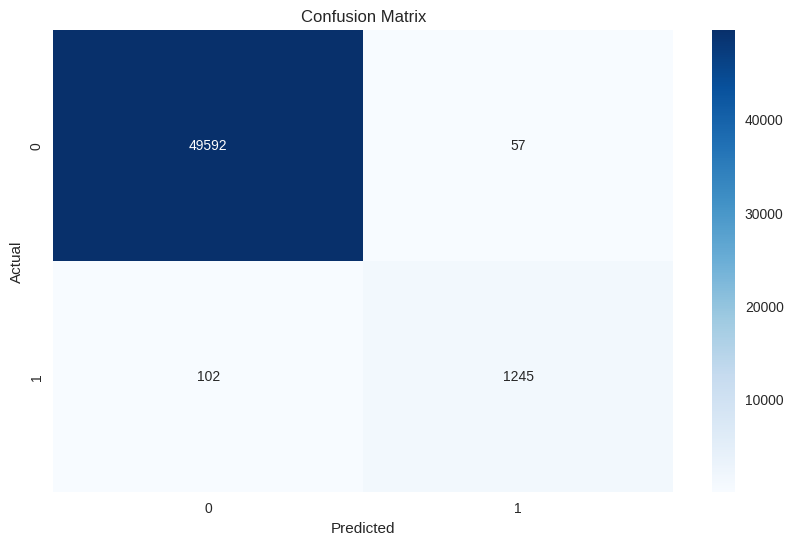

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=10, criterion='entropy', random_state=0)

#Train the model using the training sets
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test.fillna(0))

model_result(y_test,y_pred, version='ExtraTreesClassifier_entropy')

## Random Forest

roc_auc_score :  0.9618258930475906
accuracy_score:  0.9973919523099851
precision_score:  0.975705329153605
recall_score:  0.9242761692650334
f1-score : 0.9492947007243614
confusion_matrix:  [[49618    31]
 [  102  1245]]

confusion_matrix



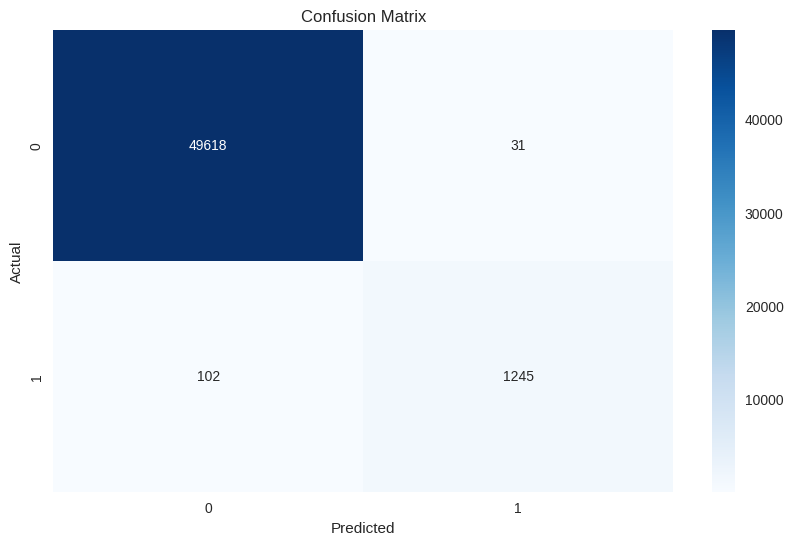

In [ ]:
from sklearn.ensemble import RandomForestClassifier


random_forest_clf = RandomForestClassifier(max_depth=20)

#Train the model using the training sets
random_forest_clf.fit(x_train, y_train)
y_pred = random_forest_clf.predict(x_test.fillna(0))

model_result(y_test,y_pred, version='RandomForestClassifier')

## Neural Network

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y_int, random_state=42, test_size=0.25, shuffle=True)

In [ ]:
# computing class weights for unbalenced data
from sklearn.utils import class_weight

weight = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_train), y = y_train)
weights = {i : weight[i] for i in range(2)}
weights

{0: 0.5137446774215213, 1: 18.68885902760811}

In [ ]:
from numpy import argmax
from keras.utils import to_categorical

# one hot encoding
y_train = to_categorical(y_train)
# print('y_train onehot:')
# print(y_train)

# one hot encoding
y_test = to_categorical(y_test)
# print('y_test onehot:')
# print(y_test)

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
  ])
model

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
model.fit(x_train, y_train, batch_size=256, epochs=20, class_weight=weights)

Epoch 1/20
598/598 [==============================] - 3s 2ms/step - loss: 0.2882 - accuracy: 0.9202
Epoch 2/20
598/598 [==============================] - 1s 2ms/step - loss: 0.1496 - accuracy: 0.9551
Epoch 3/20
598/598 [==============================] - 1s 2ms/step - loss: 0.1324 - accuracy: 0.9656
Epoch 4/20
598/598 [==============================] - 2s 3ms/step - loss: 0.1176 - accuracy: 0.9745
Epoch 5/20
598/598 [==============================] - 2s 4ms/step - loss: 0.1095 - accuracy: 0.9784
Epoch 6/20
598/598 [==============================] - 1s 2ms/step - loss: 0.1024 - accuracy: 0.9803
Epoch 7/20
598/598 [==============================] - 1s 2ms/step - loss: 0.0960 - accuracy: 0.9811
Epoch 8/20
598/598 [==============================] - 1s 2ms/step - loss: 0.0943 - accuracy: 0.9819
Epoch 9/20
598/598 [==============================] - 1s 2ms/step - loss: 0.0936 - accuracy: 0.9803
Epoch 10/20
598/598 [==============================] - 1s 2ms/step - loss: 0.0910 - accuracy: 0.9806

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.09156301617622375
Test accuracy: 0.9755862951278687


In [ ]:
y_pred = model.predict(x_test)
actual = np.argmax(y_test,axis=1)
predicted = np.argmax(y_pred,axis=1)
print(f"Actual: {actual}")
print(f"Predicted: {predicted}")

1594/1594 [==============================] - 3s 2ms/step
Actual: [0 0 0 ... 0 0 0]
Predicted: [0 0 0 ... 0 0 0]


roc_auc_score :  0.9578497698236572
accuracy_score:  0.9755863204957251
precision_score:  0.521004942339374
recall_score:  0.9391239792130661
f1-score : 0.6701986754966888
confusion_matrix:  [[48486  1163]
 [   82  1265]]

confusion_matrix



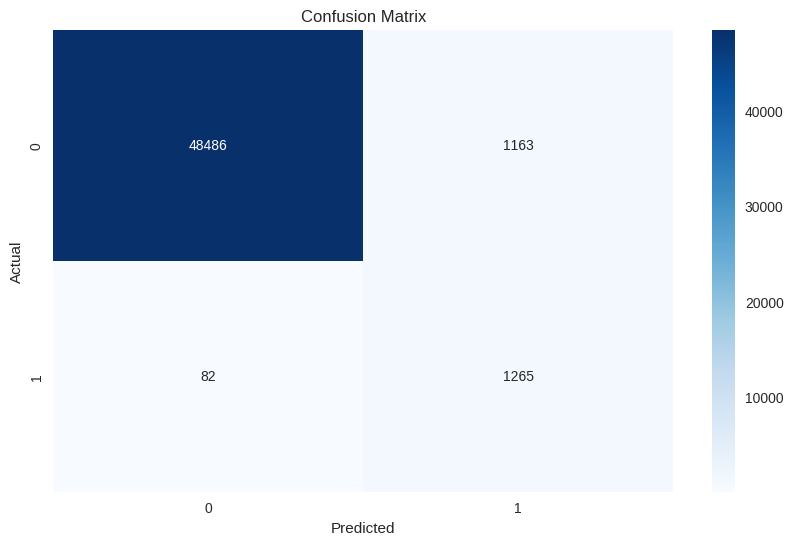

In [ ]:
model_result(actual, predicted, version='Neural Network')

# prediction

In [ ]:
import urllib.request
def get_html_from_url(url_str:str):
    """ get html source from url"""
    fp = urllib.request.urlopen(url_str)
    mybytes = fp.read()

    html_doc = mybytes.decode("utf8")
    fp.close()
    return html_doc

In [ ]:
def traverse_h1(t, current_path=None):
        """find text in input tag and its children"""
        if current_path is None:
            current_path = [t.name] # example -> current_path = ['h1']
        for tag in t.find_all(recursive=False):

            if not tag.find():        
                    content = tag.find(string=True) # each string in tag as a content
                    print(content)                             
            else:
                traverse_h1(tag, current_path + [tag.name])

In [ ]:
def predict_desc(url_str:str):
    html_doc = get_html_from_url(url_str)
    soup = BeautifulSoup(html_doc, "html.parser")

    # finding title and description in the web page if exists
    try:
        description = soup.find('meta', {'property': 'og:description'})["content"]
    except:
        description = False
    try:
        title = soup.find('meta', {'property': 'og:title'})["content"]
    except: # use h1 as title
        title = traverse_h1(soup.h1)
        # title = traverse_h1(soup.h1).text.strip()
        print(title)

    if not description : # since some pages have description:og tag!
        output = feature_extractor(html_doc, title, description=None, ignore_ratio=4, training_mode=False)
        output['depth'] = zscore(output['depth'])
        output = normalize_dom_intersection(output)
        X = output.drop(['content'],axis=1)
        # print(X)
        y_pred = clf.predict(X)
        main_content_index = [i for i, y in enumerate(y_pred) if y == 1]
        # print(main_content_index)
        pred_decription = output["content"].iloc[main_content_index[0]]
        print('pred_decription is:', pred_decription)

    else:
      print('description exists!')
      print('NO NEEED TO PREDICT!')
      print(description)

In [ ]:
predict_desc(url_str="http://www.python.org")

description exists!
NO NEEED TO PREDICT!
The official home of the Python Programming Language
